In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [93]:
from sklearn.model_selection import train_test_split
x = data.drop(columns='Class', axis=1)
y = data['Class']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, stratify=y, shuffle=True, random_state=10)

In [94]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score, precision_score ,average_precision_score, precision_recall_curve, f1_score

실험 시나리오 1 - XGBoost

In [95]:
from xgboost import XGBClassifier
model = XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3)
model.fit(train_x, train_y)

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12,
              min_child_weight=3)

In [96]:
pred = model.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.79      0.87       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [97]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', auc)
print('Precision: ', precision)
print('Recall: ', recall)
print('Precision-Recall: ', precision_recall)
print('F1-score: ', f1)

AUC:  0.8942878398099812
Precision:  0.97
Recall:  0.7886178861788617
Precision-Recall:  0.7653245078755666
F1-score:  0.8699551569506726


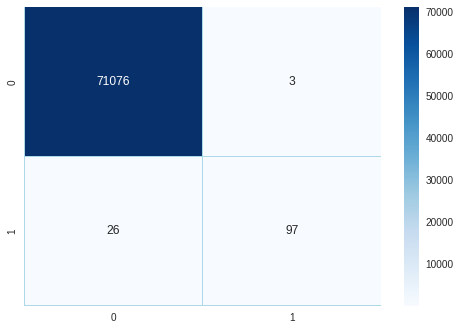

In [98]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

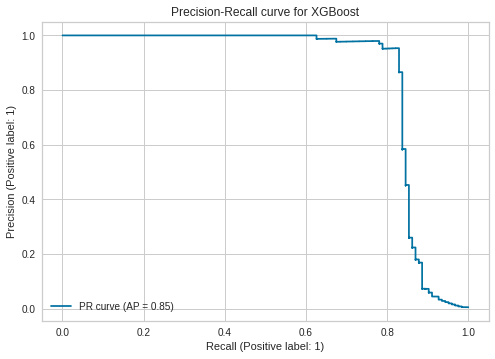

In [99]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, test_x, test_y, name="PR curve"
)
_ = display.ax_.set_title("Precision-Recall curve for XGBoost")

In [102]:
from sklearn.metrics import auc
precision, recall, _ = precision_recall_curve(test_y, pred)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

PR AUC: 0.879


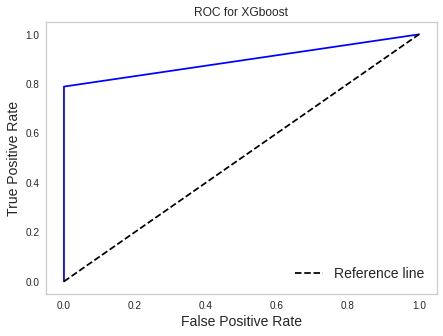

In [64]:
roc_auc_xgboost = np.mean(auc)
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(test_y, pred)

# plot 
plt.figure(figsize=(7,5))
plt.plot(fpr_xgboost, tpr_xgboost, color='blue')
plt.plot([0,1], [0,1], color='black', ls='--', label='Reference line')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC for XGboost', fontsize=12)
plt.legend(loc=4, fontsize=14)
plt.grid(False)
plt.show()

실험 시나리오 2 - test set의 base rate를 변경하여 실험

In [24]:
# test dataset Class 0, 1 나누기
test_x['Class'] = test_y

index2 = test_x.index[test_x.Class == 0]
test_1 = test_x.drop(index2, axis=0)
index1 = test_x.index[test_x.Class == 1]
test_0 = test_x.drop(index1, axis=0)

print(test_0.shape)
print(test_1.shape)

(71079, 31)
(123, 31)


In [25]:
# base rate 1:1인 test set
test_0_br_1 = test_0.sample(n=len(test_1))
test_br1 = pd.concat([test_0_br_1, test_1])
test_br1 = test_br1.sample(frac=1)
X_test_br1 = test_br1.drop('Class', axis=1)
y_test_br1 = test_br1['Class']

# base rate 1:10인 test set
test_0_br_10 = test_0.sample(n=len(test_1)*10)
test_br10 = pd.concat([test_0_br_10, test_1])
test_br10 = test_br10.sample(frac=1)
X_test_br10 = test_br10.drop('Class', axis=1)
y_test_br10 = test_br10['Class']

# base rate 1:100인 test set
test_0_br_100 = test_0.sample(n=len(test_1)*100)
test_br100 = pd.concat([test_0_br_100, test_1])
test_br100 = test_br100.sample(frac=1)
X_test_br100 = test_br100.drop('Class', axis=1)
y_test_br100 = test_br100['Class']

# base rate 1:577.87인 test set (원본)
X_test_brreal = test_x.drop('Class', axis=1)
y_test_brreal = test_x['Class']

In [26]:
print(X_test_br1.shape, y_test_br1.shape)
print(X_test_br10.shape, y_test_br10.shape)
print(X_test_br100.shape, y_test_br100.shape)
print(X_test_brreal.shape, y_test_brreal.shape)

(246, 30) (246,)
(1353, 30) (1353,)
(12423, 30) (12423,)
(71202, 30) (71202,)


1. Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=32)
lr.fit(train_x, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=32)

In [28]:
# base rate = 1:1
pred = lr.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       123
           1       1.00      0.70      0.82       123

    accuracy                           0.85       246
   macro avg       0.88      0.85      0.85       246
weighted avg       0.88      0.85      0.85       246



In [29]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_lr_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_lr_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br1))

AUC:  0.8495934959349594
Precision:  1.0
Recall:  0.6991869918699187
Precision-Recall:  0.8495934959349594
F1-score:  0.8229665071770336


In [30]:
# base rate = 1:10
pred = lr.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1230
           1       0.99      0.70      0.82       123

    accuracy                           0.97      1353
   macro avg       0.98      0.85      0.90      1353
weighted avg       0.97      0.97      0.97      1353



In [31]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_lr_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_lr_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br10))

AUC:  0.8491869918699188
Precision:  0.9885057471264368
Recall:  0.6991869918699187
Precision-Recall:  0.7184969968821946
F1-score:  0.8190476190476191


In [32]:
# base rate = 1:100
pred = lr.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.97      0.70      0.81       123

    accuracy                           1.00     12423
   macro avg       0.98      0.85      0.90     12423
weighted avg       1.00      1.00      1.00     12423



In [33]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_lr_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_lr_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_br100))

AUC:  0.8494715447154472
Precision:  0.9662921348314607
Recall:  0.6991869918699187
Precision-Recall:  0.6785972376355202
F1-score:  0.8113207547169811


In [34]:
# base rate = 1:577.87
pred = lr.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.72      0.70      0.71       123

    accuracy                           1.00     71202
   macro avg       0.86      0.85      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [35]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_lr_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_lr_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_lr_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_lr_brreal))

AUC:  0.8493543254345303
Precision:  0.7166666666666667
Recall:  0.6991869918699187
Precision-Recall:  0.5016036591645937
F1-score:  0.7078189300411523


2. MLP

In [36]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(train_x, train_y)

MLPClassifier()

In [37]:
# base rate = 1:1
pred = mlp.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88       123
           1       1.00      0.73      0.85       123

    accuracy                           0.87       246
   macro avg       0.89      0.87      0.86       246
weighted avg       0.89      0.87      0.86       246



In [38]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_mlp_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_mlp_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br1))

AUC:  0.8658536585365854
Precision:  1.0
Recall:  0.7317073170731707
Precision-Recall:  0.8658536585365854
F1-score:  0.8450704225352113


In [39]:
# base rate = 1:10
pred = mlp.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1230
           1       0.98      0.73      0.84       123

    accuracy                           0.97      1353
   macro avg       0.98      0.87      0.91      1353
weighted avg       0.97      0.97      0.97      1353



In [40]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_mlp_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_mlp_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br10))

AUC:  0.865040650406504
Precision:  0.9782608695652174
Recall:  0.7317073170731707
Precision-Recall:  0.7401908801696713
F1-score:  0.8372093023255813


In [41]:
# base rate = 1:100
pred = mlp.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.90      0.73      0.81       123

    accuracy                           1.00     12423
   macro avg       0.95      0.87      0.90     12423
weighted avg       1.00      1.00      1.00     12423



In [42]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_mlp_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_mlp_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_br100))

AUC:  0.8654471544715446
Precision:  0.9
Recall:  0.7317073170731707
Precision-Recall:  0.661192948563149
F1-score:  0.8071748878923767


In [43]:
# base rate = 1:577.87
pred = mlp.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.56      0.73      0.63       123

    accuracy                           1.00     71202
   macro avg       0.78      0.87      0.82     71202
weighted avg       1.00      1.00      1.00     71202



In [44]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_mlp_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_mlp_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_mlp_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_mlp_brreal))

AUC:  0.8653542142562775
Precision:  0.5590062111801242
Recall:  0.7317073170731707
Precision-Recall:  0.40949240513709056
F1-score:  0.6338028169014084


3. Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=32)
rfc.fit(train_x, train_y)

RandomForestClassifier(random_state=32)

In [46]:
# base rate = 1:1
pred = rfc.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.81      1.00      0.89       123
           1       1.00      0.76      0.87       123

    accuracy                           0.88       246
   macro avg       0.90      0.88      0.88       246
weighted avg       0.90      0.88      0.88       246



In [47]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_rf_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_rf_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br1))

AUC:  0.8821138211382114
Precision:  1.0
Recall:  0.7642276422764228
Precision-Recall:  0.8821138211382114
F1-score:  0.8663594470046084


In [48]:
# base rate = 1:10
pred = rfc.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1230
           1       1.00      0.76      0.87       123

    accuracy                           0.98      1353
   macro avg       0.99      0.88      0.93      1353
weighted avg       0.98      0.98      0.98      1353



In [49]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_rf_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_rf_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br10))

AUC:  0.8821138211382114
Precision:  1.0
Recall:  0.7642276422764228
Precision-Recall:  0.7856614929785662
F1-score:  0.8663594470046084


In [50]:
# base rate = 1:100
pred = rfc.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.98      0.76      0.86       123

    accuracy                           1.00     12423
   macro avg       0.99      0.88      0.93     12423
weighted avg       1.00      1.00      1.00     12423



In [51]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_rf_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_rf_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_br100))

AUC:  0.8820325203252033
Precision:  0.9791666666666666
Recall:  0.7642276422764228
Precision-Recall:  0.7506406128417721
F1-score:  0.858447488584475


In [52]:
# base rate = 1:577.87
pred = rfc.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.76      0.85       123

    accuracy                           1.00     71202
   macro avg       0.98      0.88      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [53]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_rf_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_rf_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_rf_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_rf_brreal))

AUC:  0.8820927178587616
Precision:  0.9690721649484536
Recall:  0.7642276422764228
Precision-Recall:  0.7409990277442674
F1-score:  0.8545454545454546


4. XGBoost (Our model)

In [65]:
from xgboost import XGBClassifier
model = XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3)
model.fit(train_x, train_y)

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12,
              min_child_weight=3)

In [66]:
# base rate = 1:1
pred = model.predict(X_test_br1)
print (classification_report(y_test_br1, pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90       123
           1       1.00      0.79      0.88       123

    accuracy                           0.89       246
   macro avg       0.91      0.89      0.89       246
weighted avg       0.91      0.89      0.89       246



In [67]:
precision_recall= average_precision_score(y_test_br1, pred)
precision_xgb_br1 = precision_score(y_test_br1, pred)
recall = recall_score(y_test_br1, pred)
auc  = roc_auc_score(y_test_br1, pred)
f1_xgb_br1 = f1_score(y_test_br1, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br1))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br1))

AUC:  0.8943089430894309
Precision:  1.0
Recall:  0.7886178861788617
Precision-Recall:  0.8943089430894309
F1-score:  0.8818181818181818


In [68]:
# base rate = 1:10
pred = model.predict(X_test_br10)
print (classification_report(y_test_br10, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1230
           1       1.00      0.79      0.88       123

    accuracy                           0.98      1353
   macro avg       0.99      0.89      0.94      1353
weighted avg       0.98      0.98      0.98      1353



In [69]:
precision_recall= average_precision_score(y_test_br10, pred)
precision_xgb_br10 = precision_score(y_test_br10, pred)
recall = recall_score(y_test_br10, pred)
auc  = roc_auc_score(y_test_br10, pred)
f1_xgb_br10 = f1_score(y_test_br10, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br10))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br10))

AUC:  0.8943089430894309
Precision:  1.0
Recall:  0.7886178861788617
Precision-Recall:  0.8078344419807834
F1-score:  0.8818181818181818


In [70]:
# base rate = 1:100
pred = model.predict(X_test_br100)
print (classification_report(y_test_br100, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12300
           1       0.98      0.79      0.87       123

    accuracy                           1.00     12423
   macro avg       0.99      0.89      0.94     12423
weighted avg       1.00      1.00      1.00     12423



In [71]:
precision_recall= average_precision_score(y_test_br100, pred)
precision_xgb_br100 = precision_score(y_test_br100, pred)
recall = recall_score(y_test_br100, pred)
auc  = roc_auc_score(y_test_br100, pred)
f1_xgb_br100 = f1_score(y_test_br100, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_br100))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_br100))

AUC:  0.8942276422764228
Precision:  0.9797979797979798
Recall:  0.7886178861788617
Precision-Recall:  0.7747791039266528
F1-score:  0.8738738738738739


In [72]:
# base rate = 1:577.87
pred = model.predict(X_test_brreal)
print (classification_report(y_test_brreal, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.79      0.87       123

    accuracy                           1.00     71202
   macro avg       0.98      0.89      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [73]:
precision_recall= average_precision_score(y_test_brreal, pred)
precision_xgb_brreal = precision_score(y_test_brreal, pred)
recall = recall_score(y_test_brreal, pred)
auc  = roc_auc_score(y_test_brreal, pred)
f1_xgb_brreal = f1_score(y_test_brreal, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision_xgb_brreal))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1_xgb_brreal))

AUC:  0.8942878398099812
Precision:  0.97
Recall:  0.7886178861788617
Precision-Recall:  0.7653245078755666
F1-score:  0.8699551569506726


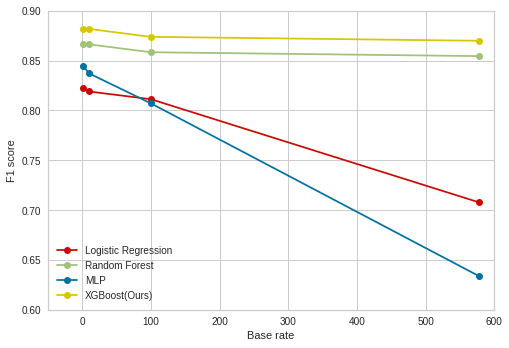

In [74]:
import matplotlib.legend as legend
index = [1, 10, 100, 577.87]

LR=[np.mean(f1_lr_br1), np.mean(f1_lr_br10), np.mean(f1_lr_br100), np.mean(f1_lr_brreal)]
lr,=plt.plot(index, LR, 'ro-')

RF=[np.mean(f1_rf_br1), np.mean(f1_rf_br10), np.mean(f1_rf_br100),np.mean(f1_rf_brreal)]
rf,=plt.plot(index, RF, 'go-')

MLP=[np.mean(f1_mlp_br1), np.mean(f1_mlp_br10), np.mean(f1_mlp_br100), np.mean(f1_mlp_brreal)]
mlp,=plt.plot(index, MLP, 'bo-')

XGB=[np.mean(f1_xgb_br1), np.mean(f1_xgb_br10), np.mean(f1_xgb_br100), np.mean(f1_xgb_brreal)]
xgb,=plt.plot(index, XGB, 'yo-')

plt.legend([lr, rf, mlp, xgb],['Logistic Regression','Random Forest','MLP', 'XGBoost(Ours)'])
plt.xlim([-50, 600])
plt.ylim([0.6, 0.9])
plt.xlabel('Base rate')
plt.ylabel('F1 score')
plt.grid(True)
plt.show()

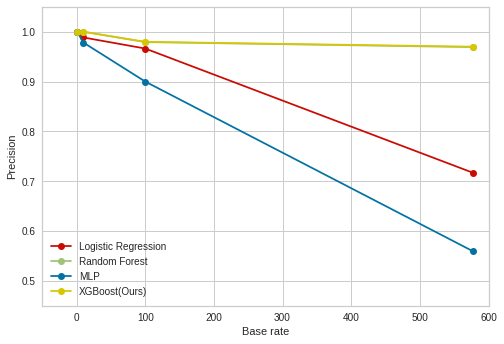

In [76]:
import matplotlib.legend as legend
index = [1, 10, 100, 577.87]

LR=[np.mean(precision_lr_br1), np.mean(precision_lr_br10), np.mean(precision_lr_br100), np.mean(precision_lr_brreal)]
lr,=plt.plot(index, LR, 'ro-')

RF=[np.mean(precision_rf_br1), np.mean(precision_rf_br10), np.mean(precision_rf_br100),np.mean(precision_rf_brreal)]
rf,=plt.plot(index, RF, 'go-')

MLP=[np.mean(precision_mlp_br1), np.mean(precision_mlp_br10), np.mean(precision_mlp_br100), np.mean(precision_mlp_brreal)]
mlp,=plt.plot(index, MLP, 'bo-')

XGB=[np.mean(precision_xgb_br1), np.mean(precision_xgb_br10), np.mean(precision_xgb_br100), np.mean(precision_xgb_brreal)]
xgb,=plt.plot(index, XGB, 'yo-')

plt.legend([lr, rf, mlp, xgb],['Logistic Regression','Random Forest','MLP', 'XGBoost(Ours)'])
plt.xlim([-50, 600])
plt.ylim([0.45, 1.05])
plt.xlabel('Base rate')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

실험 시나리오 3 - 다른 모델들과 비교 (Logistic Regression, KNN, RandomForest, MLP, XGBoost with SMOTE)

1. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=32)
lr.fit(train_x, train_y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=32)

In [ ]:
pred = lr.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.72      0.70      0.71       123

    accuracy                           1.00     71202
   macro avg       0.86      0.85      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.8493543254345303
Precision:  0.7166666666666667
Recall:  0.6991869918699187
Precision-Recall:  0.5016036591645937
F1-score:  0.7078189300411523


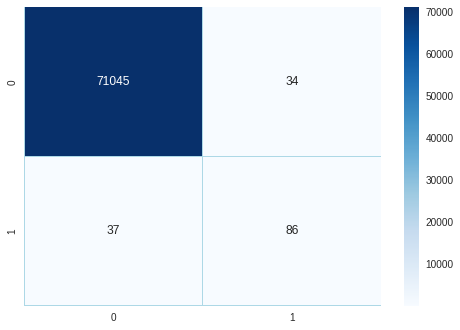

In [ ]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

2. KNN (n_neighbors = 3) 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_x, train_y)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred = knn.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.88      0.06      0.11       123

    accuracy                           1.00     71202
   macro avg       0.94      0.53      0.55     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.5284482501263623
Precision:  0.875
Recall:  0.056910569105691054
Precision-Recall:  0.05142591568748754
F1-score:  0.10687022900763359


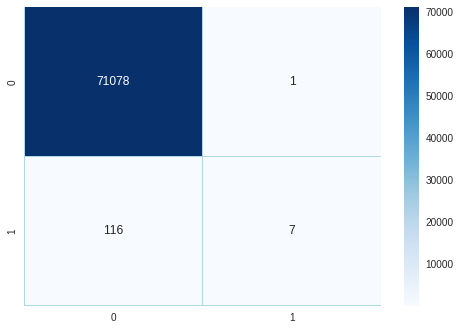

In [ ]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

3. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, random_state=32)
rfc.fit(train_x, train_y)

RandomForestClassifier(random_state=32)

In [ ]:
pred = rfc.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.97      0.76      0.85       123

    accuracy                           1.00     71202
   macro avg       0.98      0.88      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [ ]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.8820927178587616
Precision:  0.9690721649484536
Recall:  0.7642276422764228
Precision-Recall:  0.7409990277442674
F1-score:  0.8545454545454546


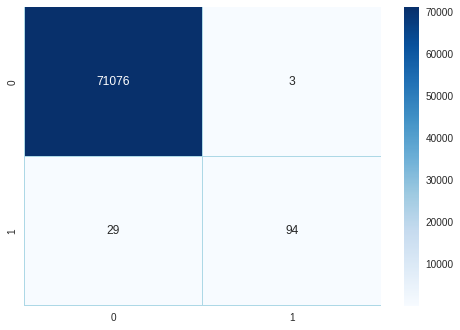

In [ ]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

4. Neural Network (MLP)

In [82]:
from sklearn.neural_network import MLPClassifier

In [83]:
mlp = MLPClassifier()
mlp.fit(train_x, train_y)

MLPClassifier()

In [84]:
pred = mlp.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.55      0.72      0.62       123

    accuracy                           1.00     71202
   macro avg       0.77      0.86      0.81     71202
weighted avg       1.00      1.00      1.00     71202



In [85]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.8612680703264214
Precision:  0.5460122699386503
Recall:  0.7235772357723578
Precision-Recall:  0.39555956365655304
F1-score:  0.6223776223776224


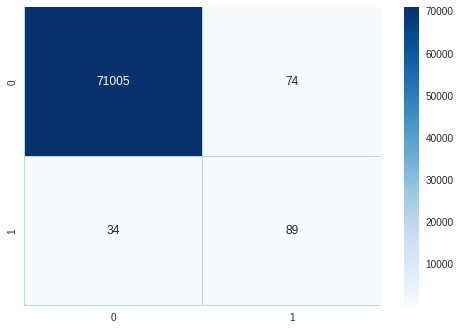

In [86]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')

* Oversampling(SMOTE) 적용한 xgboost

In [87]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
train_x_over, train_y_over = smote.fit_resample(train_x, train_y)
print('Distribution of training set after applying SMOTE :\n',pd.Series(train_y_over).value_counts() )

Distribution of training set after applying SMOTE :
 0    213236
1    213236
Name: Class, dtype: int64


In [88]:
from xgboost import XGBClassifier
xgb = XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3)
xgb.fit(train_x_over, train_y_over)

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12,
              min_child_weight=3)

In [89]:
pred = xgb.predict(test_x)
print (classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.89      0.83      0.86       123

    accuracy                           1.00     71202
   macro avg       0.94      0.91      0.93     71202
weighted avg       1.00      1.00      1.00     71202



In [90]:
precision_recall= average_precision_score(test_y, pred)
precision = precision_score(test_y, pred)
recall = recall_score(test_y, pred)
auc  = roc_auc_score(test_y, pred)
f1 = f1_score(test_y, pred)

print('AUC: ', np.mean(auc))
print('Precision: ', np.mean(precision))
print('Recall: ', np.mean(recall))
print('Precision-Recall: ', np.mean(precision_recall))
print('F1-score: ', np.mean(f1))

AUC:  0.9145426987971816
Precision:  0.8869565217391304
Recall:  0.8292682926829268
Precision-Recall:  0.7358198560021145
F1-score:  0.857142857142857


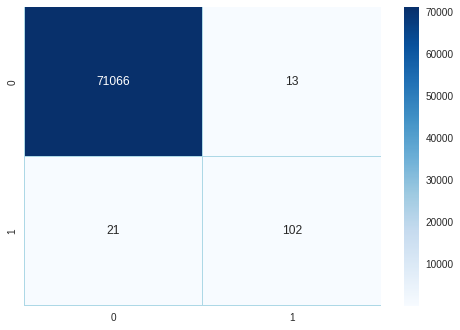

In [91]:
cf_matrix = confusion_matrix(test_y, pred)
sns.heatmap(cf_matrix, annot=True, linewidths=0.1, cmap="Blues", fmt='d', linecolor='lightblue')